# General problem analysis

In [2]:
from Source_code.z_utils.data_preprocessing import xml_to_df
import os

# Extract data from XML and create a DataFrame
xml_files = []
data_path = "../b_dataset_generation/data/"
results_folders = ["human_medical_data/", "veterinary_medical_data/"]
for folder in results_folders:
    files = [data_path + folder + file for file in os.listdir(data_path + folder)]
    xml_files.append(files)

hum_df, vet_df = xml_to_df(xml_files)

  1%|          | 925/105930 [00:00<00:11, 9206.50it/s]

Processing medical field: human_medicine


 32%|███▏      | 33851/105930 [00:05<00:15, 4760.94it/s] 

Processing medical field: veterinary_medicine


100%|██████████| 105930/105930 [00:16<00:00, 6281.72it/s]


In [7]:
hum_df.head()

,pmid,text_types,title,abstract,meshtermlist,labels
0,21686333,[Journal Article],acute vomiting and mental status changes: a ca...,"in this article, we describe a 5- year-old gir...",[],0
1,21686334,[Journal Article],efficacy of low-dose topical mitomycin c treat...,primary acquired melanosis (pam) with atypical...,[],0
2,21686335,[Journal Article],incidental adrenocortical oncocytoma.,a 66-year-old man with a history of hypertensi...,[],0
3,21686336,[Journal Article],can salmonella enteritidis cause fatal necroti...,this is a presentation of a case of mono micro...,[],0
4,21686337,[Journal Article],fatality from minor cervical trauma in ankylos...,cervical injury is a serious and often fatal c...,[],0


In [5]:
vet_df.head()

,pmid,text_types,title,abstract,meshtermlist,labels
0,25126422,[Journal Article],psychogenic stress in hospitalized dogs: cross...,evidence to support the existence of health co...,[],1
1,26479001,[Journal Article],temperature and relative humidity inside trail...,the effect of bedding levels and trailer compa...,[],1
2,26479002,[Journal Article],tourists' perceptions of the free-roaming dog ...,a study was undertaken to establish how visiti...,[],1
3,26479003,[Journal Article],leptospira spp. in domestic cats from differen...,leptospirosis is an emerging zoonotic disease ...,[],1
4,26479004,[Journal Article],"effect of season, transport length, deck locat...",the objective of this study was to investigate...,[],1


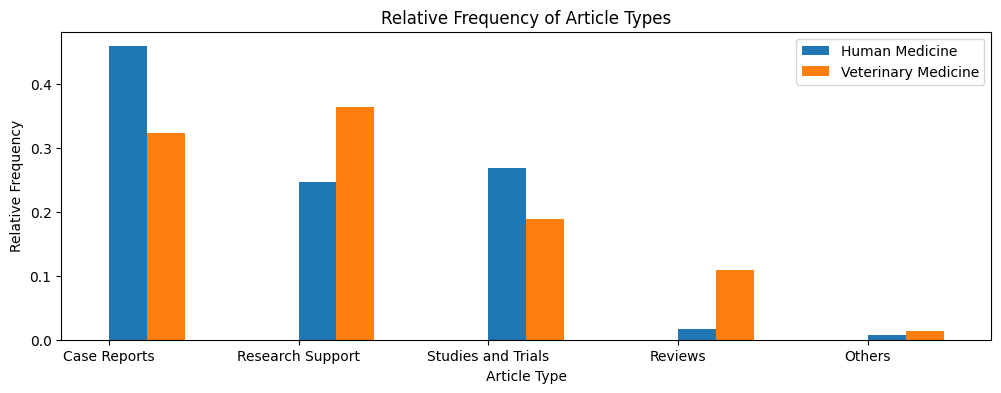

In [4]:
import pandas as pd
import matplotlib.pyplot as plt


hum_exploded_df = hum_df.explode("text_types")
vet_exploded_df = vet_df.explode("text_types")

hum_text_type_counts = hum_exploded_df['text_types'].value_counts()
vet_text_type_counts = vet_exploded_df['text_types'].value_counts()

hum_text_type_counts_aligned, vet_text_type_counts_aligned = hum_text_type_counts.align(vet_text_type_counts, join='outer', fill_value=0)
hum_text_type_counts_aligned = hum_text_type_counts_aligned.sort_values(ascending=False)
hum_text_type_counts_aligned /= hum_text_type_counts_aligned[1:].sum()
vet_text_type_counts_aligned = vet_text_type_counts_aligned.sort_values(ascending=False)
vet_text_type_counts_aligned /= vet_text_type_counts_aligned[1:].sum()
text_type_counts_aligned = pd.concat([hum_text_type_counts_aligned, 
                                      vet_text_type_counts_aligned], 
                                     keys=["Human Medicine", "Veterinary Medicine"], 
                                     axis=1)

text_type_rates = text_type_counts_aligned

research_support_row = pd.DataFrame({
    "Human Medicine": [text_type_rates["Human Medicine"][text_type_rates["Human Medicine"].index.str.contains("research support", case=False)].sum()],
    "Veterinary Medicine": [text_type_rates["Veterinary Medicine"][text_type_rates["Veterinary Medicine"].index.str.contains("research support", case=False)].sum()]
}, index=["Research Support"])

hum_idx = text_type_rates["Human Medicine"].index.str.contains("study|trial", case=False)
vet_idx = text_type_rates["Veterinary Medicine"].index.str.contains("study|trial", case=False)
studies_trials_row = pd.DataFrame({
    "Human Medicine": [text_type_rates["Human Medicine"][hum_idx].sum()],
    "Veterinary Medicine": [text_type_rates["Veterinary Medicine"][vet_idx].sum()]
}, index=["Studies and Trials"])

review_row = pd.DataFrame({
    "Human Medicine": [text_type_rates["Human Medicine"][text_type_rates["Human Medicine"].index.str.contains("review", case=False)].sum()],
    "Veterinary Medicine": [text_type_rates["Veterinary Medicine"][text_type_rates["Veterinary Medicine"].index.str.contains("review", case=False)].sum()]
}, index=["Reviews"])

hum_idx = ~text_type_rates["Human Medicine"].index.str.contains("journal article|case reports|study|trial|research support|review", case=False)
vet_idx = ~text_type_rates["Veterinary Medicine"].index.str.contains("journal article|case reports|study|trial|research support|review", case=False)
others_row = pd.DataFrame({
    "Human Medicine": [text_type_rates["Human Medicine"][hum_idx].sum()],
    "Veterinary Medicine": [text_type_rates["Veterinary Medicine"][vet_idx].sum()]
}, index=["Others"])

reformatted_df = pd.concat([text_type_rates[1:2], research_support_row, studies_trials_row, review_row, others_row])
reformatted_df.plot(kind='bar', position=0, width=0.4, figsize=(12, 4))

plt.xlabel('Article Type')
plt.xticks(rotation=0, ha='center')
plt.ylabel('Relative Frequency')
plt.legend()
plt.savefig('relative_frequency_article_types.pdf', format="pdf", bbox_inches="tight")
plt.title('Relative Frequency of Article Types')
plt.show()
plt.close()

### Character counts

In [5]:
df = pd.concat([hum_df, vet_df])

df_exploded = df.explode("text_types")
jour_articles_df = df_exploded[df_exploded["text_types"] == "Journal Article"]
case_rep_df = df_exploded[df_exploded["text_types"] == "Case Reports"]

In [6]:
import re


avg_title = jour_articles_df["title"].str.len().mean()
print(f"Average title character count of all journal articles: {avg_title}")
res_sum = 0
for text in jour_articles_df["title"]:
    res_sum += len(re.findall(r'\w+', text))
print(f"Average title word count of all journal articles: {res_sum/len(jour_articles_df.title)}")

avg_abstract = jour_articles_df["abstract"].str.len().mean()
print(f"Average abstract length of all journal articles: {avg_abstract}")
res_sum = 0
for text in jour_articles_df["abstract"]:
    res_sum += len(re.findall(r'\w+', text))
print(f"Average abstract word count of all journal articles: {res_sum/len(jour_articles_df.abstract)}")

abstract_title = jour_articles_df[["title", "abstract"]].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
avg_abstract_title = abstract_title.str.len().mean()
print(f"Average abstract+title length of all journal articles: {avg_abstract_title}")
res_sum = 0
for text in abstract_title:
    res_sum += len(re.findall(r'\w+', text))
print(f"Average abstract+title word count of all journal articles: {res_sum/len(abstract_title)}")

Average title character count of all journal articles: 98.49365709768841
Average title word count of all journal articles: 13.61657251923114
Average abstract length of all journal articles: 984.8753783570148
Average abstract word count of all journal articles: 150.3347085928011
Average abstract+title length of all journal articles: 1084.3690354547032
Average abstract+title word count of all journal articles: 163.95128111203223


In [7]:
avg_title = case_rep_df["title"].str.len().mean()
print(f"Average title character count of all case reports: {avg_title}")
res_sum = 0
for text in case_rep_df["title"]:
    res_sum += len(re.findall(r'\w+', text))
print(f"Average title word count of all case reports: {res_sum/len(case_rep_df.title)}")

avg_abstract = case_rep_df["abstract"].str.len().mean()
print(f"Average title character count of all case reports: {avg_abstract}")
res_sum = 0
for text in case_rep_df["abstract"]:
    res_sum += len(re.findall(r'\w+', text))
print(f"Average abstract word count of all case reports: {res_sum/len(case_rep_df.abstract)}")

abstract_title = case_rep_df[["title", "abstract"]].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
avg_abstract_title = abstract_title.str.len().mean()
print(f"Average abstract+title character count of all case reports: {avg_abstract_title}")
res_sum = 0
for text in abstract_title:
    res_sum += len(re.findall(r'\w+', text))
print(f"Average abstract+title word count of all case reports: {res_sum/len(abstract_title)}")

Average title character count of all case reports: 83.94746286218562
Average title word count of all case reports: 11.429445506692161
Average title character count of all case reports: 808.2143550522136
Average abstract word count of all case reports: 119.41838505662598
Average abstract+title character count of all case reports: 893.1618179143992
Average abstract+title word count of all case reports: 130.84783056331813


In [8]:
avg_title = df["title"].str.len().mean()
print(f"Average title character count of all text types: {avg_title}")
res_sum = 0
for text in df["title"]:
    res_sum += len(re.findall(r'\w+', text))
print(f"Average title word count of all text types: {res_sum/len(df.title)}")

avg_abstract = df["abstract"].str.len().mean()
print(f"Average abstract character count of all text types: {avg_abstract}")
res_sum = 0
for text in df["abstract"]:
    res_sum += len(re.findall(r'\w+', text))
print(f"Average abstract word count of all text types: {res_sum/len(df.abstract)}")

abstract_title = df[["title", "abstract"]].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
avg_abstract_title = abstract_title.str.len().mean()
print(f"Average abstract+title character count of all text types: {avg_abstract_title}")
res_sum = 0
for text in abstract_title:
    res_sum += len(re.findall(r'\w+', text))
print(f"Average abstract+title word count of all text types: {res_sum/len(abstract_title)}")

Average title character count of all text types: 98.49156990465401
Average title word count of all text types: 13.624384027187766
Average abstract character count of all text types: 983.669564806948
Average abstract word count of all text types: 150.0639950910979
Average abstract+title character count of all text types: 1083.161134711602
Average abstract+title word count of all text types: 163.68837911828567
